# Lab 6: Introduction to Mining Network Data

In this lab, we will be focusing on two concepts for mining network data: PageRank and Link Prediction. First, we will apply PageRank to airports/flights data to determine which airports are the most "important" in the network. Then we will apply a few different approaches for link prediction in order to predict mutual likes between Facebook food pages.

In [2]:
import pandas as pd
import numpy as np
#%pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

### 1. Network Generation/Analysis & PageRank

PageRank is a link analysis approach for computing the importance of nodes in a network. The main idea is that a node is more "important" if it has more in-edges from other nodes, especially from other important nodes. To show how it works, we will apply PageRank to airports/flights data in order to determine which airports are the most "important" in the network.

In [3]:
# data source: https://www.kaggle.com/tylerx/flights-and-airports-data?select=flights.csv

# load the airports data 

airports = pd.read_csv('airports.csv')
print("Number of rows: {}, Number of columns: {}".format(airports.shape[0], airports.shape[1]))
airports.head()

Number of rows: 365, Number of columns: 4


,airport_id,city,state,name
0,10165,Adak Island,AK,Adak
1,10299,Anchorage,AK,Ted Stevens Anchorage International
2,10304,Aniak,AK,Aniak Airport
3,10754,Barrow,AK,Wiley Post/Will Rogers Memorial
4,10551,Bethel,AK,Bethel Airport


In [4]:
# load the flights data

flights = pd.read_csv('flights.csv')
print("Number of rows: {}, Number of columns: {}".format(flights.shape[0], flights.shape[1]))
flights.head()

Number of rows: 2702218, Number of columns: 7


,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,DepDelay,ArrDelay
0,19,5,DL,11433,13303,-3,1
1,19,5,DL,14869,12478,0,-8
2,19,5,DL,14057,14869,-4,-15
3,19,5,DL,15016,11433,28,24
4,19,5,DL,11193,12892,-6,-11


We see that the airports data contains information about the location and name of airports in the United States and that the flights data contains information about a selection of flights between these airports. Next, let's explore the data to get a better understanding of what it contains.

#### 1.1 Data Exploration

In [136]:
### YOUR CODE: explore the data

### SOME questions to consider:
### how many unique airports are there in the data?
unq_airports = airports['airport_id'].nunique()
print(unq_airports)
### how many airports are there in each state?
#print(airports.groupby('state').count())
### how many unique origin airports (flights data) are there in the data? which is the most frequent?
unq_orig = flights.iloc[:,3].nunique()
### how many unique destination airports (flights data) are there in the data? which is the most frequent?

365


#### 1.2 Network Analysis

Next, we will create a directed network from our flights data. To do so, we must first transform our data a bit.

In [135]:
# we want three columns: 
# (1) 'OriginAirportID'
# (2) 'DestAirportID'
# (3) 'count' (number of flights from (1) to (2))
flights2 = flights.groupby(['OriginAirportID', 'DestAirportID']).size().reset_index(name='count')
flights2.head()
flights2

,OriginAirportID,DestAirportID,count
0,10140,10397,565
1,10140,10821,406
2,10140,11259,1555
3,10140,11292,1519
4,10140,11298,1610
...,...,...,...
2508,15376,14107,2035
2509,15376,14679,595
2510,15376,14747,213
2511,15376,14771,250


In [144]:
# as airport IDs are rather meaningless to us, lets use the airport names instead
originAirports = [airports[airports.airport_id==id_].name.iloc[0] for id_ in list(flights2['OriginAirportID'])]
destAirports = [airports[airports.airport_id==id_].name.iloc[0] for id_ in list(flights2['DestAirportID'])]
flights2['OriginAirport'] = originAirports
flights2['DestAirport'] = destAirports
flights2.head()
flights2

,OriginAirportID,DestAirportID,count,OriginAirport,DestAirport
0,10140,10397,565,Albuquerque International Sunport,Hartsfield-Jackson Atlanta International
1,10140,10821,406,Albuquerque International Sunport,Baltimore/Washington International Thurgood Ma...
2,10140,11259,1555,Albuquerque International Sunport,Dallas Love Field
3,10140,11292,1519,Albuquerque International Sunport,Denver International
4,10140,11298,1610,Albuquerque International Sunport,Dallas/Fort Worth International
...,...,...,...,...,...
2508,15376,14107,2035,Tucson International,Phoenix Sky Harbor International
2509,15376,14679,595,Tucson International,San Diego International
2510,15376,14747,213,Tucson International,Seattle/Tacoma International
2511,15376,14771,250,Tucson International,San Francisco International


In [140]:
# load the data as a directed graph

# use function 'from_pandas_edgelist' to load the flights df as a directed network graph (G)
G = nx.from_pandas_edgelist(flights2, source='OriginAirport',target='DestAirport', edge_attr ='count', create_using=nx.DiGraph())
nx.is_directed(G) # check, expect 'True'

True

In [143]:
# explore the generated network
print("Numer of airports in the network:", G.number_of_nodes())
print("Number of (unique) flights:", G.number_of_edges())

# how do we access the number of flights from one airport to another?
print("Number of flights from Albuquerque International Sunport to Hartsfield-Jackson Atlanta International:",
    G["Albuquerque International Sunport"]["Hartsfield-Jackson Atlanta International"]["count"]) # example


Numer of airports in the network: 70
Number of (unique) flights: 2513
Number of flights from Albuquerque International Sunport to Hartsfield-Jackson Atlanta International: 565


2513

In [61]:
### YOUR CODE: what is the average shortest path length between two airports? How would you interpret this?
### HINT: see the networkx documentation to find the appropiate function
nx.average_shortest_path_length(G)

1.4805383022774328

#### 1.3 PageRank

Now that we have created our network and done some preliminary exploration and analysis, we are ready to apply PageRank to our airports/flights network.  We will use the 'count' or the number of flights from the origin airport to the destination airport as the weight since this indicates the strength of the connection (i.e., more flights from airport A to B will give more importance to B).

In [151]:
# applying PageRank
pageranks = nx.pagerank(G, weight='count') 
pageranks = {k:v for k, v in sorted(pageranks.items(), key=lambda t: t[1], reverse=True)}
#pageranks

In [148]:
# what are the 10 airports with the highest PageRank? 
highest_pagerank_airports = list(pageranks.keys())[0:10]
count = 1
for airport in highest_pagerank_airports:
    print("{}. {}".format(count, airport))
    count += 1

1. Hartsfield-Jackson Atlanta International
2. Chicago O'Hare International
3. Los Angeles International
4. Dallas/Fort Worth International
5. Denver International
6. Phoenix Sky Harbor International
7. San Francisco International
8. McCarran International
9. Charlotte Douglas International
10. George Bush Intercontinental/Houston


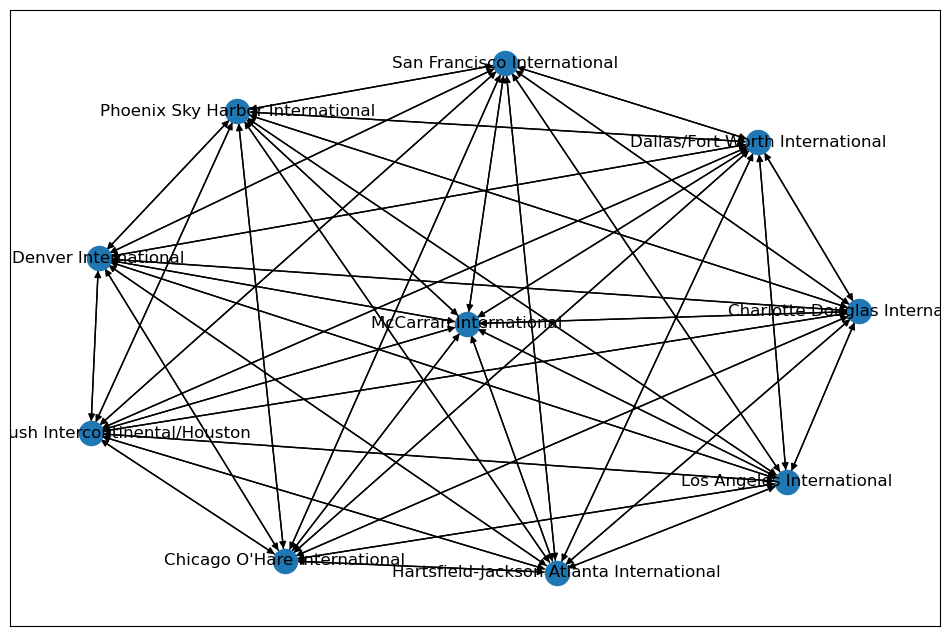

In [154]:
# visualize top 10 (NOTE: only includes edges between nodes in the top 10)
plt.figure(figsize=(12,8)) 
top10 = G.subgraph(highest_pagerank_airports)
nx.draw_networkx(top10)

In [79]:
# what are the 10 airports with the lowest PageRank?
lowest_pagerank_airports = list(pageranks.keys())[-10:]
count = 1
for airport in lowest_pagerank_airports:
    print("{}. {}".format(count, airport))
    count += 1

1. Southwest Florida International
2. Richmond International
3. Louisville International-Standiford Field
4. Tucson International
5. Reno/Tahoe International
6. Palm Beach International
7. Norfolk International
8. Theodore Francis Green State
9. Long Beach Airport
10. Ted Stevens Anchorage International


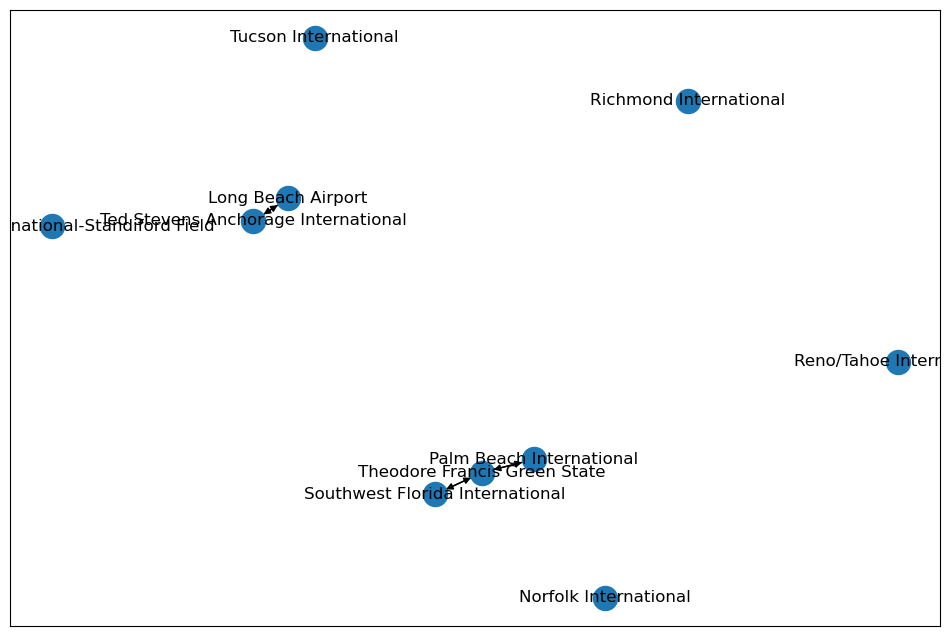

In [80]:
# visualize bottom 10 (NOTE: only includes edges between nodes in the bottom 10)
plt.figure(figsize=(12,8)) 
bottom10 = G.subgraph(lowest_pagerank_airports)
nx.draw_networkx(bottom10)

Looking at the results, we would consider those with the highest PageRank values to be the most "important" airports in our network and those with the lowest PageRank values to be the least "important" airports in our network. We see that the airports with the highest PageRank values are much more connected to one another than the airports with the lowest PageRank values. Overall, this can help us understand which airports are most essential to air travel within the US and where we might want to focus our efforts to ensure that flights are taking off and landing on time.

#### 1.4 Dead-Ends & Spider Traps

There are two main issues that we may face when applying PageRank to network data: (1) dead-ends and (2) spider traps. A dead-end is a node that has no out-edges. This will result in the importance being "leaked" out of the network. Spider traps occur when all out-links are within a group. This will result in the "trapping" of importance in the network. Both of these issues can be solved with teleporting. Let's check to see if our network is suffering from either.

In [88]:
# check for dead-ends in our network
set(flights2.OriginAirportID) == set(flights2.DestAirportID) 

True

We see that our data has no dead-ends as every airport is both an origin and destination airport in our network (i.e., every airport has in-links and out-links). Next, let's check for spider traps in our network.

/var/folders/p2/5q_v38t93k39gw_qqvly_8mm0000gn/T/ipykernel_75103/3294542701.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list(pageranks.values()), kde=False)


<Axes: >

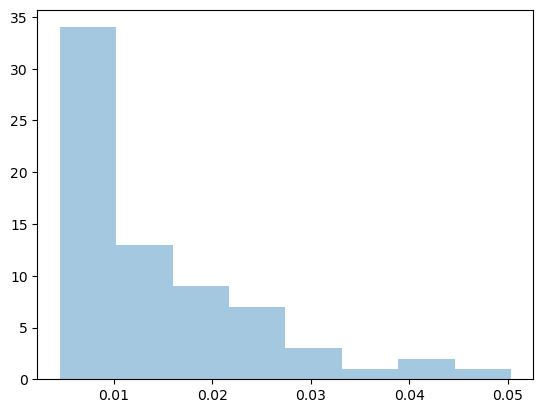

In [89]:
# check for spider traps: is any node/group of nodes "trapping" importance?

# plot distribution of PageRank values
sns.distplot(list(pageranks.values()), kde=False)

Looking at the distribution of PageRank values, we do not see any concerningly high values. This indicates that we do not have any airports "trapping" PageRank importance. This makes sense as airports are well-connected to one another to support the needs of all travelers so we would not expect any dead-ends or spider traps. 

### 2. Link Prediction

By implementing link prediction, we can predict which new connections (edges) we may expect between nodes in the future. To do so, we need to be able to measure the "proximity" between the nodes in our network. We will also need training data (snapshot(s) of the network at time x) and testing data (snapshot(s) of the network at a later time y). Then, our strategy will be to pick unconnected nodes in our training data, score them with some proximity measure and use the results to predict the most likely new edges. To assess our predictions, we will look in our testing data to see if such edges do exist. 

To showcase this, we will experiment with (1) Common Neighbors, (2) Jaccard Similarity, and (3) Adamic/Adar using an undirected network of mutually liked Food pages (e.g., restaurants, chefs) on Facebook.

#### 2.1 Import & Explore the Data

In [155]:
# source: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

# data source: http://networkrepository.com/fb-pages-food.php

# load the data 

with open("fb-pages-food/fb-pages-food.nodes") as f:
    fb_pages = f.read().splitlines() 

with open("fb-pages-food/fb-pages-food.edges") as f:
    fb_edges = f.read().splitlines() 

In [156]:
# transform nodes (pages) into a dataframe

ids = []
names = []
new_ids = []
for node in fb_pages[1:]:
    ids.append(node.split(",")[0])
    names.append(node.split(",")[1])
    new_ids.append(node.split(",")[2])

fb_pages_df = pd.DataFrame({"id":ids, "name":names, "new_id":new_ids})
print("Number of rows: {}, Number of columns: {}".format(fb_pages_df.shape[0], fb_pages_df.shape[1]))
fb_pages_df.head()

Number of rows: 620, Number of columns: 3


,id,name,new_id
0,402449106435352,Josh Marks,386
1,368969274888,Blue Ribbon Restaurants,473
2,765596333518863,Pat Neely,1
3,136870209668885,La Griglia,542
4,840078802741859,Jose Garces,189


In [157]:
# transform edges (mutual likes) into a dataframe
pages1 = []
pages2 = []
for edge in fb_edges:
    pages1.append(edge.split(",")[0])
    pages2.append(edge.split(",")[1])

fb_edges_df = pd.DataFrame({"page1":pages1, "page2":pages2})
print("Number of rows: {}, Number of columns: {}".format(fb_edges_df.shape[0], fb_edges_df.shape[1]))
fb_edges_df.head()

Number of rows: 2102, Number of columns: 2


,page1,page2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


We see that we have two main data sources: one with the information about each node (i.e., each Facebook food page) and another one with information about each edge (i.e.., each pair of Facebook food pages that have mutually liked one another).

#### 2.2 Create 'Training' and 'Testing' Networks

We will treat the entire network as our 'test' data. Then, we will remove some of the edges between the pages to serve as our 'training' data for which we will try to predict the removed edges, or mutual likes between the Facebook food pages. However, we need to be careful regarding which edges we remove from the network as we want to ensure that we have the same number of nodes in the network and that the network does not become fragmented after removing them.

In [164]:
# the full network - this will serve as our 'test' data

G = nx.from_pandas_edgelist(fb_edges_df, "page1", "page2", create_using=nx.Graph()) # undirected
print("Numer of pages in the network:", G.number_of_nodes()) # check
print("Number of mutual likes:", G.number_of_edges()) # check

Numer of pages in the network: 620
Number of mutual likes: 2102


In [165]:
# what edges can be dropped but will not drop the node from the network or create an unconnected network?

# source: https://www.analyticsvidhya.com/blog/2020/01/link-prediction-how-to-predict-your-future-connections-on-facebook/

initial_node_count = len(G.nodes) # how many nodes are in our full network? want to preserve this #!

fb_edges_df_temp = fb_edges_df.copy()

removable_edges_idx = []



for i in fb_edges_df.index.values: # loop through all edges in our data
  
    # remove the edge from the data and build a new graph without it
    G_temp = nx.from_pandas_edgelist(fb_edges_df_temp.drop(index = i), "page1", "page2", create_using=nx.Graph())
  
    # check if there is fragmentation in the graph or if the number of nodes in the network changed
    if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        removable_edges_idx.append(i)
        fb_edges_df_temp = fb_edges_df_temp.drop(index = i)


len(removable_edges_idx) # number of edges we CAN drop

1483

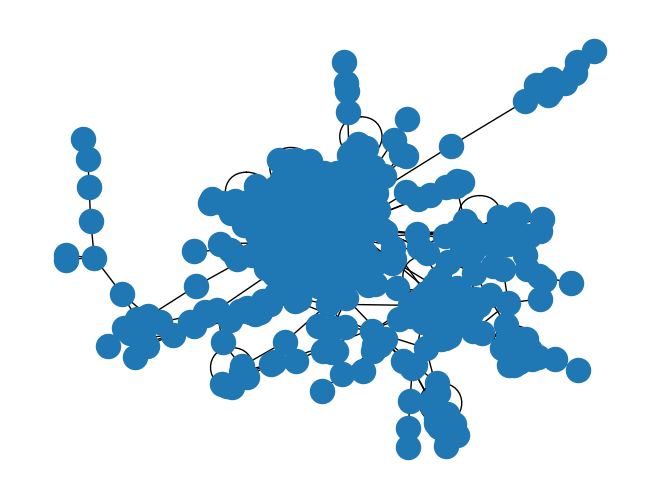

In [162]:
nx.draw(G_temp)

There are 1,483 edges that we *can* drop but we will only drop 200 of them so our network does not become too sparse.

In [166]:
random.seed(671) # for reproducibility
random_edges_idx = random.sample(removable_edges_idx, 200)
len(random_edges_idx) # check

200

In [167]:
# drop these 200 removable edges to form our training data
fb_df_training = fb_edges_df.drop(index=random_edges_idx)

# build training network/graph
G_train = nx.from_pandas_edgelist(fb_df_training, "page1", "page2", create_using=nx.Graph())
print("Number of nodes in training data:", G_train.number_of_nodes()) # check - we preserved the number of nodes
print("Number of edges in our training data:", G_train.number_of_edges()) # 2102 (all edges) - 200 (removed edges)

Number of nodes in training data: 620
Number of edges in our training data: 1902


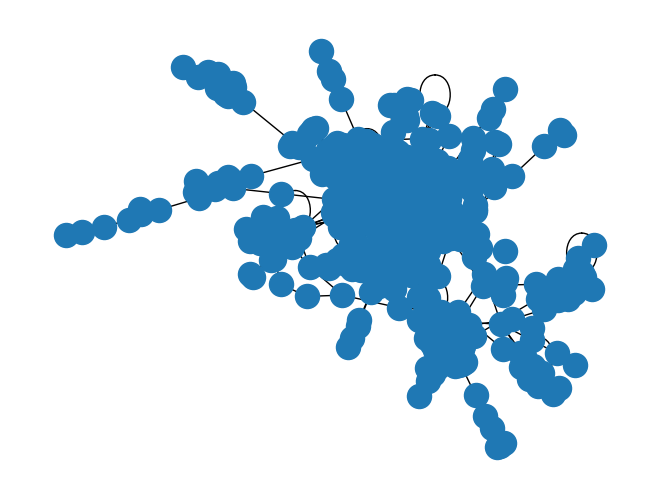

In [170]:
nx.draw(G_train)

Our goal is to predict the 200 edges that we removed from the network. We will try using (1) Common Neighbors, (2) Jaccard Similarity, and (3) Adamic/Adar to do so.

In [169]:
# get a list of our 'true' edges (those that we removed) for assessing performance

true_edges_df = fb_edges_df.loc[random_edges_idx]
true_edges_list = []
for index, row in true_edges_df.iterrows():
    true_edges_list.append([row.page1, row.page2])
    # also include reverse of pair since we have an undirected network (i.e., A->B and B->A indicate the same thing)
    true_edges_list.append([row.page2, row.page1])

len(true_edges_list)


400

#### 2.3 Common Neighbors

First, we will try to predict the edges using a simple approach - the number of common neighbors (i.e., friends) between each pair of pages.

In [125]:
ebunch = nx.non_edges(G_train) # only look at pairs of pages without an edge
common_neighbor_counts = [(page1, page2, len(sorted(nx.common_neighbors(G_train, page1, page2)))) for page1, page2 in ebunch]

In [172]:
common_neighbors_df = pd.DataFrame(common_neighbor_counts, columns=['Page1', 'Page2', '# Common Neighbors'])
common_neighbors_df["# Common Neighbors"].describe() # max number of common neighbors is 1, most are 0


count    189997.000000
mean          0.134455
std           0.614983
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.000000
Name: # Common Neighbors, dtype: float64

In [175]:
# use a cutoff to make predictions - predict an edge for # common neighbors >= 8

cn_predicted_pairs = []
for index, row in common_neighbors_df.iterrows():
    if row['# Common Neighbors'] >= 10:
        pair = [row.Page1, row.Page2]
        cn_predicted_pairs.append(pair)

print("Number of predicted edges:", len(cn_predicted_pairs))

Number of predicted edges: 79


In [176]:
# assess performance
count = 0
for pair in cn_predicted_pairs:
    if pair in true_edges_list:
        count += 1
        
print("Number of correct predictions:", count)
print("Prediction Accuracy: {}%".format(round((count/len(cn_predicted_pairs)*100),2)))

Number of correct predictions: 18
Prediction Accuracy: 22.78%


#### 2.4 Jaccard Similarity

Next, we will try using Jaccard Similarity to predict the edges. It is similar to common neighbors but it divides it by the set of all neighbors (i.e., friends) among the two pages.

In [202]:
jaccard_similarities = nx.jaccard_coefficient(G_train)
jaccard_df = pd.DataFrame(jaccard_similarities)
jaccard_df.columns = ['Page1', 'Page2', 'Jaccard Similarity']
jaccard_df

,Page1,Page2,Jaccard Similarity
0,245,462,0.000000
1,245,51,0.000000
2,245,386,0.052632
3,245,47,0.000000
4,245,248,0.206897
...,...,...,...
189992,278,351,0.000000
189993,278,531,0.000000
189994,531,437,0.000000
189995,531,351,0.153846


In [198]:
jaccard_df['Jaccard Similarity'].describe() # see that most are 0

count    189997.000000
mean          0.041211
std           0.207400
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.934489
Name: Jaccard Similarity, dtype: float64

In [199]:
# use a cutoff to make predictions - predict an edge for jaccard similarity >= 0.5

jac_predicted_pairs = []
for index, row in jaccard_df.iterrows():
    if row['Jaccard Similarity'] >= 0.51:
        pair = [row.Page1, row.Page2]
        jac_predicted_pairs.append(pair)

print("Number of predicted edges:", len(jac_predicted_pairs))

Number of predicted edges: 4683


In [200]:
# assess performance
count = 0
for pair in jac_predicted_pairs:
    if pair in true_edges_list:
        count += 1
        
print("Number of correct predictions:", count)
print("Prediction Accuracy: {}%".format(round((count/len(jac_predicted_pairs)*100),2)))

Number of correct predictions: 155
Prediction Accuracy: 3.31%


One hypothesis for why common neighbors could be outperforming Jaccard Similarity by such a large margin is that the  number of common neighbors may be the factor that is more important in this case. As a result, the denominator for Jaccard Similarity could be de-emphasizing the number of common neighbors between the two pages. Let's test out this hypothesis:

In [109]:
# testing hypothesis

# compute the set of neighbors of each pair 

ebunch = nx.non_edges(G_train) 
set_neighbor_counts =  []
for page1, page2 in ebunch:
    edges = []
    for edge in G_train.edges([page1, page2]): # loop through edges
        if edge[1] not in edges:
            edges.append(edge[1])
    edges_set = set(edges) # use set to get a unique list of neighbors
    set_neighbor_counts.append((page1, page2, len(edges_set)))


In [195]:
#set_neighbor_counts

In [183]:
set_neighbors_df = pd.DataFrame(set_neighbor_counts)
set_neighbors_df.columns = ['Page1', 'Page2', '# in Neighbors Set']
set_neighbors_df['# in Neighbors Set'].describe()
set_neighbors_df

,Page1,Page2,# in Neighbors Set
0,245,462,14
1,245,51,14
2,245,386,19
3,245,47,16
4,245,248,29
...,...,...,...
189992,278,351,12
189993,278,531,7
189994,531,437,13
189995,531,351,13


In [111]:
# add info to dataframe
combined_df = jaccard_df.merge(common_neighbors_df, on = ['Page1', 'Page2']).merge(
                                                    set_neighbors_df, on = ['Page1', 'Page2'])
combined_df.sort_values(by='# Common Neighbors', ascending=False)[0:10]

,Page1,Page2,Jaccard Similarity,# Common Neighbors,# in Neighbors Set
169652,265,89,0.260163,32,123
186855,340,70,0.444444,28,63
109961,56,265,0.195489,26,133
189664,67,70,0.328358,22,67
169841,611,89,0.362069,21,58
140762,545,374,0.904762,19,21
130352,603,265,0.145161,18,124
169581,265,87,0.131783,17,129
12174,289,131,0.615385,16,26
107158,389,265,0.122137,16,131


In [112]:
combined_df.sort_values(by='# Common Neighbors')[0:10]

,Page1,Page2,Jaccard Similarity,# Common Neighbors,# in Neighbors Set
0,245,462,0.0,0,14
124350,460,363,0.0,0,15
124351,460,335,0.0,0,12
124352,460,464,0.0,0,7
124353,460,218,0.0,0,7
124354,460,147,0.0,0,17
124355,460,528,0.0,0,7
124356,460,457,0.0,0,8
124358,460,128,0.0,0,20
124349,460,443,0.0,0,8


Looking at the dataframe, we can see that the Jaccard Similarity is calculated by dividing '# Common Neighbors' by '# in Neighbors Set'. We see that our hypothesis may be correct since those with many common neighbors tend to also have many more neighbors in the set whereas those with few common neighbors tend to have many fewer neighbors in the set. Therefore, when we divide by the number of neighbors in the set, we end up canceling out some of the effect of having many common neighbors resulting in a lower Jaccard Similarity value. This serves as a good reminder that Jaccard Similarity prefers nodes with fewer neighbors!

#### 2.5 Adamic/Adar

Lastly, we will use Adamic/Adar to predict edges for our data. Adamic/Adar is the most complex measure of the three and it works by placing more weight on rare neighbors, similar to IDF.

In [113]:
### YOUR CODE: use nx.adamic_adar_index to make predictions
### hint: make predictions using a chosen cutoff value (i.e., predict an edge when the adamic/adar value >= X)
### How does it compare to Common Neighbors and Jaccard Similarity? Which measure does the best in this case?

Overall, link prediction is an extremely difficult task which is evident by the low prediction accuracy values we saw in this lab. This is especially true when we are working with social network data as there are a multitude of factors that influence human behavior and the decisions we make such as which pages we like on Facebook. However, utilizing link prediction can still provide valuable insights as we can use the results to influence decisions such as which friends or pages to suggest to a user.